In [163]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
from sklearn.svm import SVC 

In [5]:
phnompenh_lulc = gpd.read_file('./eo4sd_phnom_penh_lulcvhr_2017/EO4SD_PHNOM_PENH_LULCVHR_2017.shp')
phnompenh_lulc.head(2)

,C_L4,N_L4,C_L3,N_L3,C_L2,N_L2,C_L1,N_L1,AREA,ID,geometry
0,11220,Discontinuous medium density urban fabric (10 ...,11200,Discontinuous Urban Fabric (Sealing level: 10%...,11000,Urban Fabric,10000,Artificial Surfaces,1590.437,1,"POLYGON ((484091.269 1286418.159, 484091.269 1..."
1,12110,Commercial and Industrial units,12100,"Industrial, Commercial, Public, Military and P...",12000,"Industrial, Commercial, Public, Military, Priv...",10000,Artificial Surfaces,6349.577,2,"POLYGON ((483875.490 1286062.818, 483875.903 1..."


In [6]:
# All Meta Data of the shape file
phnompenh_lulc_crs = phnompenh_lulc.crs
print('Shape data file crs = ',phnompenh_lulc_crs)

Shape data file crs =  EPSG:32648


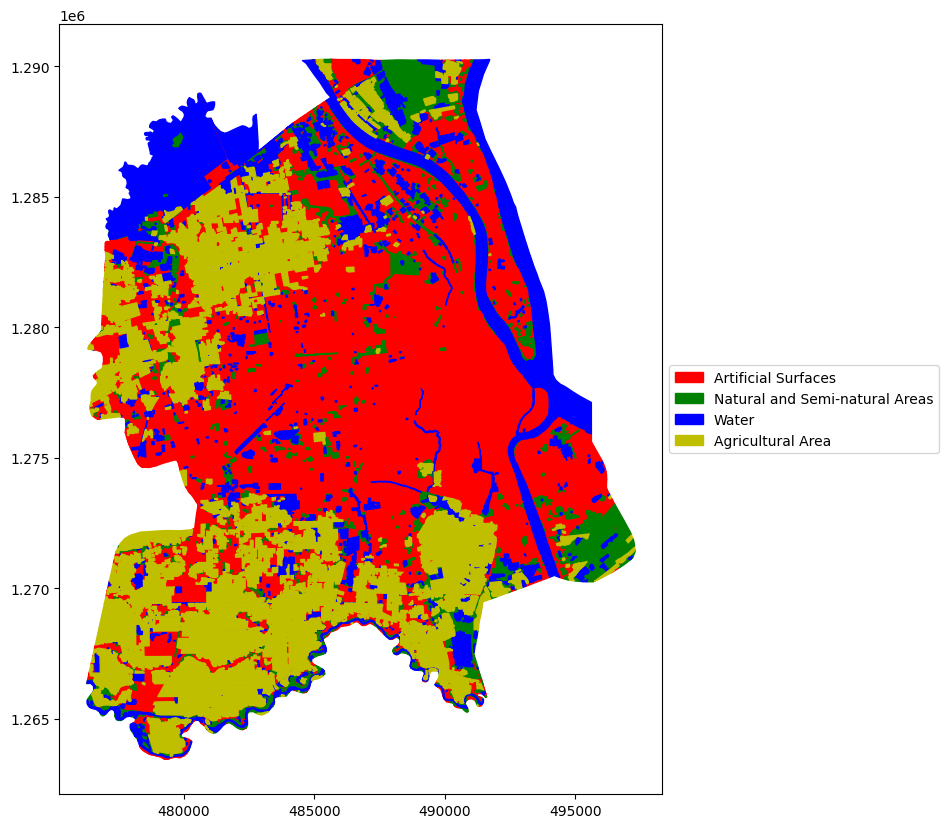

In [9]:
#Visulaize the polygons in the shape file
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

artSurf = phnompenh_lulc[phnompenh_lulc['N_L1'] == 'Artificial Surfaces']
natSemNat = phnompenh_lulc[phnompenh_lulc['N_L1'] == 'Natural and Semi-natural Areas']
water = phnompenh_lulc[phnompenh_lulc['N_L1'] == 'Water']
AgrArea = phnompenh_lulc[phnompenh_lulc['N_L1'] == 'Agricultural Area']

# Plot each class as a separate plot with the specified color
artSurf.plot( ax=ax, color = 'r', categorical=True, edgecolor="face", linewidth=1)
natSemNat.plot( ax=ax, color = 'g', categorical=True, edgecolor="face", linewidth=1)
water.plot( ax=ax, color = 'b', categorical=True, edgecolor="face", linewidth=1)
AgrArea.plot( ax=ax, color = 'y', categorical=True, edgecolor="face", linewidth=1)

# Create a legend for each class with the specified color
red_patch = mpatches.Patch(color='r', label='Artificial Surfaces')
green_patch = mpatches.Patch(color='g', label='Natural and Semi-natural Areas')
blue_patch = mpatches.Patch(color='b', label='Water')
yellow_patch = mpatches.Patch(color='y', label='Agricultural Area')

# Add the legend to the plot
plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch],  loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [58]:
artSurf_sortby_area =  artSurf.sort_values(by=['AREA'], ascending=False)
natSemNat_sortby_area = natSemNat.sort_values(by=['AREA'], ascending=False)
water_sortby_area = water.sort_values(by=['AREA'], ascending=False)
AgrArea_sortby_area = AgrArea.sort_values(by=['AREA'], ascending=False)

artSurf_sortby_area_small = artSurf_sortby_area.iloc[ :100] 
natSemNat_sortby_area_small = natSemNat_sortby_area.iloc[:100]
water_sortby_area_small = water_sortby_area.iloc[:100]
AgrArea_sortby_area_small = AgrArea_sortby_area.iloc[:100]
# AgrArea_sortby_area_small.iloc[[0]].bounds

water_sortby_area_small.C_L1 = 40000

cols = ['C_L1','ID', 'geometry']
combinedPolygons = pd.concat([artSurf_sortby_area_small, natSemNat_sortby_area_small,water_sortby_area_small,AgrArea_sortby_area_small ])
combinedPolygons = combinedPolygons[cols]

C:\Users\riyad\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [78]:
import geopandas as gpd
import shapely.geometry as geometry
import random
# polygons = combinedPolygons

points = []
c_ls = []
polygon_ids = []
num_points = 2
for idx in range(0,len(combinedPolygons)):
    polygon_geom = combinedPolygons['geometry'].iloc[idx]
    polygon_cl1 = combinedPolygons['C_L1'].iloc[idx]
    polygon_id = combinedPolygons['ID'].iloc[idx]

    polygon_poly = geometry.Polygon(polygon_geom)
    point_this_pol = 0
    
    while point_this_pol < num_points:
        # Generate a random point within the bounding box of the polygon
        point = geometry.Point([random.uniform(polygon_poly.bounds[0], polygon_poly.bounds[2]),
                                 random.uniform(polygon_poly.bounds[1], polygon_poly.bounds[3])])
        # Check if the point is within the polygon
        if polygon_poly.contains(point):
            points.append(point)
            c_ls.append(int(polygon_cl1/10000))
            polygon_ids.append(polygon_id)
            point_this_pol = point_this_pol + 1       
            
points_gdf = gpd.GeoDataFrame(geometry=points)

points_gdf = points_gdf.rename(columns={"index":"ID"})
points_gdf['ID'] = points_gdf.index 

points_gdf.crs = phnompenh_lulc.crs


points_gdf['C_L1'] = c_ls
points_gdf['PolygonID'] = polygon_ids

points_gdf.to_file('Random Points inside Polygons', driver='ESRI Shapefile', crs=points_gdf.crs)

In [79]:
points_gdf

,geometry,ID,C_L1,PolygonID
0,POINT (486323.079 1278205.685),0,1,19994
1,POINT (488465.018 1280013.829),1,1,19994
2,POINT (483884.471 1277612.980),2,1,19939
3,POINT (484059.679 1277309.570),3,1,19939
4,POINT (478923.164 1268130.598),4,1,19970
...,...,...,...,...
795,POINT (484188.660 1268047.792),795,2,9802
796,POINT (484275.019 1283436.590),796,2,1943
797,POINT (484076.861 1283463.259),797,2,1943
798,POINT (481029.590 1272142.672),798,2,11706


In [95]:
# Read the local tif files

#Put the path to the folder where the Sentinel-2 image is stored.
filepath="./PH_AOI_S2Bands/" 

NumOfClasses=len(points_gdf.C_L1.unique())
print('Number of Classes: ',NumOfClasses)
UniqueClasses = points_gdf.C_L1.unique()

#This list will store the numpy form of the satellite images.
S2Image=[]
transform = ()
#List of band names that we want to use.
BandNames=["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]
#The number of bands.
NumOfBands=len(BandNames)

#Read and store the each band as a numpy array.
for Band in BandNames:
    ReadBand=rio.open(filepath+f"20210331T031541_20210331T032710_T48PVT_{Band}.tif")
    ReadBandArray=ReadBand.read(1)
    S2Image.append(ReadBandArray)
    transform = ReadBand.transform

Number of Classes:  4


In [82]:
S2Image

[array([[ 883,  881,  878, ..., 1157, 1151, 1145],
        [ 877,  874,  871, ..., 1153, 1146, 1139],
        [ 879,  874,  870, ..., 1147, 1138, 1128],
        ...,
        [ 897,  927,  984, ...,  658,  660,  661],
        [ 901,  933,  996, ...,  660,  661,  662],
        [ 901,  933,  999, ...,  660,  660,  661]], dtype=uint16),
 array([[1382, 1148,  929, ..., 1224, 1160, 1154],
        [1346, 1062,  828, ..., 1340, 1304, 1288],
        [1106,  927,  797, ..., 1318, 1334, 1342],
        ...,
        [1032, 1036, 1014, ...,  619,  617,  646],
        [ 905,  968, 1003, ...,  613,  592,  633],
        [1124, 1188, 1106, ...,  615,  617,  637]], dtype=uint16),
 array([[1996, 1484, 1324, ..., 1520, 1450, 1450],
        [1898, 1446, 1210, ..., 1742, 1664, 1644],
        [1556, 1406, 1098, ..., 1710, 1704, 1726],
        ...,
        [1340, 1350, 1380, ...,  913,  953,  964],
        [1340, 1340, 1394, ...,  833,  826,  827],
        [1680, 1690, 1522, ...,  850,  861,  813]], dtype=uint

In [83]:
N=len(points_gdf["C_L1"])

#This list will store the spectrum information at each training point.
spectrum_data=[]

for n in tqdm(range(N)):
    point = points_gdf.iloc[n]
    row, col = rio.transform.rowcol(transform, point.geometry.x, point.geometry.y)
    spectrum_data_at_xy=[]
#     print(row,col)
    
    for band in S2Image:
        spectrum_data_at_xy.append(band[row,col])
    spectrum_data.append(spectrum_data_at_xy)
        
points_gdf["Spectrum_data"]=spectrum_data

100%|██████████| 800/800 [00:00<00:00, 898.94it/s]


In [89]:
points_gdf

,geometry,ID,C_L1,PolygonID,Spectrum_data
0,POINT (486323.079 1278205.685),0,1,19994,"[1458, 1001, 1238, 1308, 1689, 1704, 1718, 131..."
1,POINT (488465.018 1280013.829),1,1,19994,"[1079, 799, 989, 949, 1346, 2141, 2423, 2162, ..."
2,POINT (483884.471 1277612.980),2,1,19939,"[1044, 1290, 1666, 2030, 2215, 2444, 2586, 269..."
3,POINT (484059.679 1277309.570),3,1,19939,"[1000, 993, 1310, 1764, 2217, 2511, 2749, 2822..."
4,POINT (478923.164 1268130.598),4,1,19970,"[1295, 1182, 1550, 1980, 2803, 2959, 2937, 245..."
...,...,...,...,...,...
795,POINT (484188.660 1268047.792),795,2,9802,"[1118, 1208, 1582, 1968, 2382, 2769, 3009, 304..."
796,POINT (484275.019 1283436.590),796,2,1943,"[986, 1106, 1450, 1694, 2219, 2671, 2984, 3002..."
797,POINT (484076.861 1283463.259),797,2,1943,"[1024, 980, 1262, 1552, 2070, 2423, 2659, 2610..."
798,POINT (481029.590 1272142.672),798,2,11706,"[1891, 2996, 4028, 4264, 4202, 4192, 4264, 419..."


In [149]:
trainData=[]
trainLabel=[]
testData=[]
testLabel=[]

for i in range(1,NumOfClasses+1):
    print(i)
    Data_class_i=points_gdf[points_gdf["C_L1"]==i]["Spectrum_data"]
    Labels_class_i=points_gdf[points_gdf["C_L1"]==i]["C_L1"]
    
    Data_train, Data_test, Label_train, Label_test = train_test_split(Data_class_i, Labels_class_i, test_size=0.2)
    
    trainData.extend(Data_train)
    trainLabel.extend(Label_train)
    testData.extend(Data_test)
    testLabel.extend(Label_test)


trainData=np.array(trainData)
testData=np.array(testData)
trainLabel=np.array(trainLabel)
testLabel=np.array(testLabel)

1
2
3
4


In [113]:
# testLabel

In [150]:
trainData=np.array(trainData)
testData=np.array(testData)
trainLabel=np.array(trainLabel)
testLabel=np.array(testLabel)

In [152]:
# #Neural Network
# #Two hidden layers with 250 nodes each.
# #Two dropout layers were added to reduce the overfitting problems.

# trainData_NN=np.array(trainData)
# testData_NN=np.array(testData)
# trainLabel_NN=keras.utils.to_categorical(trainLabel)
# testLabel_NN=keras.utils.to_categorical(testLabel)

# model=Sequential()
# model.add(Dense(250,activation="relu",input_dim=12))
# model.add(Dropout(0.1))
# model.add(Dense(250,activation="relu"))
# model.add(Dropout(0.1))
# model.add(Dense(6,activation="softmax"))

# adam=Adam(lr=0.001)
# model.compile(loss="categorical_crossentropy",optimizer=adam,metrics=["accuracy"])

# model.fit(trainData_NN,trainLabel_NN,epochs=500,batch_size=150,verbose=0)
# loss,acc=model.evaluate(testData_NN,testLabel_NN)
# print("The classification accuracy is {:.4f}".format(acc))

In [143]:
#Random Forest
trainData_RF=np.array(trainData)
testData_RF=np.array(testData)
trainLabel_RF=keras.utils.to_categorical(trainLabel)
testLabel_RF=keras.utils.to_categorical(testLabel)

clf_RF=RandomForestClassifier(n_estimators=100)
clf_RF.fit(trainData_RF,trainLabel_RF)
pred_test=clf_RF.predict(testData_RF)
acc=np.sum(np.argmax(pred_test,axis=1)==np.argmax(testLabel_RF,axis=1))/(np.argmax(pred_test,axis=1).size)
print("The classification accuracy is {:.4f}".format(acc))

The classification accuracy is 0.3875


In [153]:
predicted_LULC_RF=[]
column_length=S2Image[0].shape[1]


for i in tqdm(range(S2Image[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(NumOfBands):
        spectrum_data_at_row_i.append(S2Image[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class=clf_RF.predict(spectrum_data_at_row_i_T)
    predicted_LULC_RF.append(np.argmax(predicted_class,axis=1))

predicted_LULC_RF=np.array(predicted_LULC_RF).astype(np.uint8)

100%|██████████| 3638/3638 [09:25<00:00,  6.43it/s]  


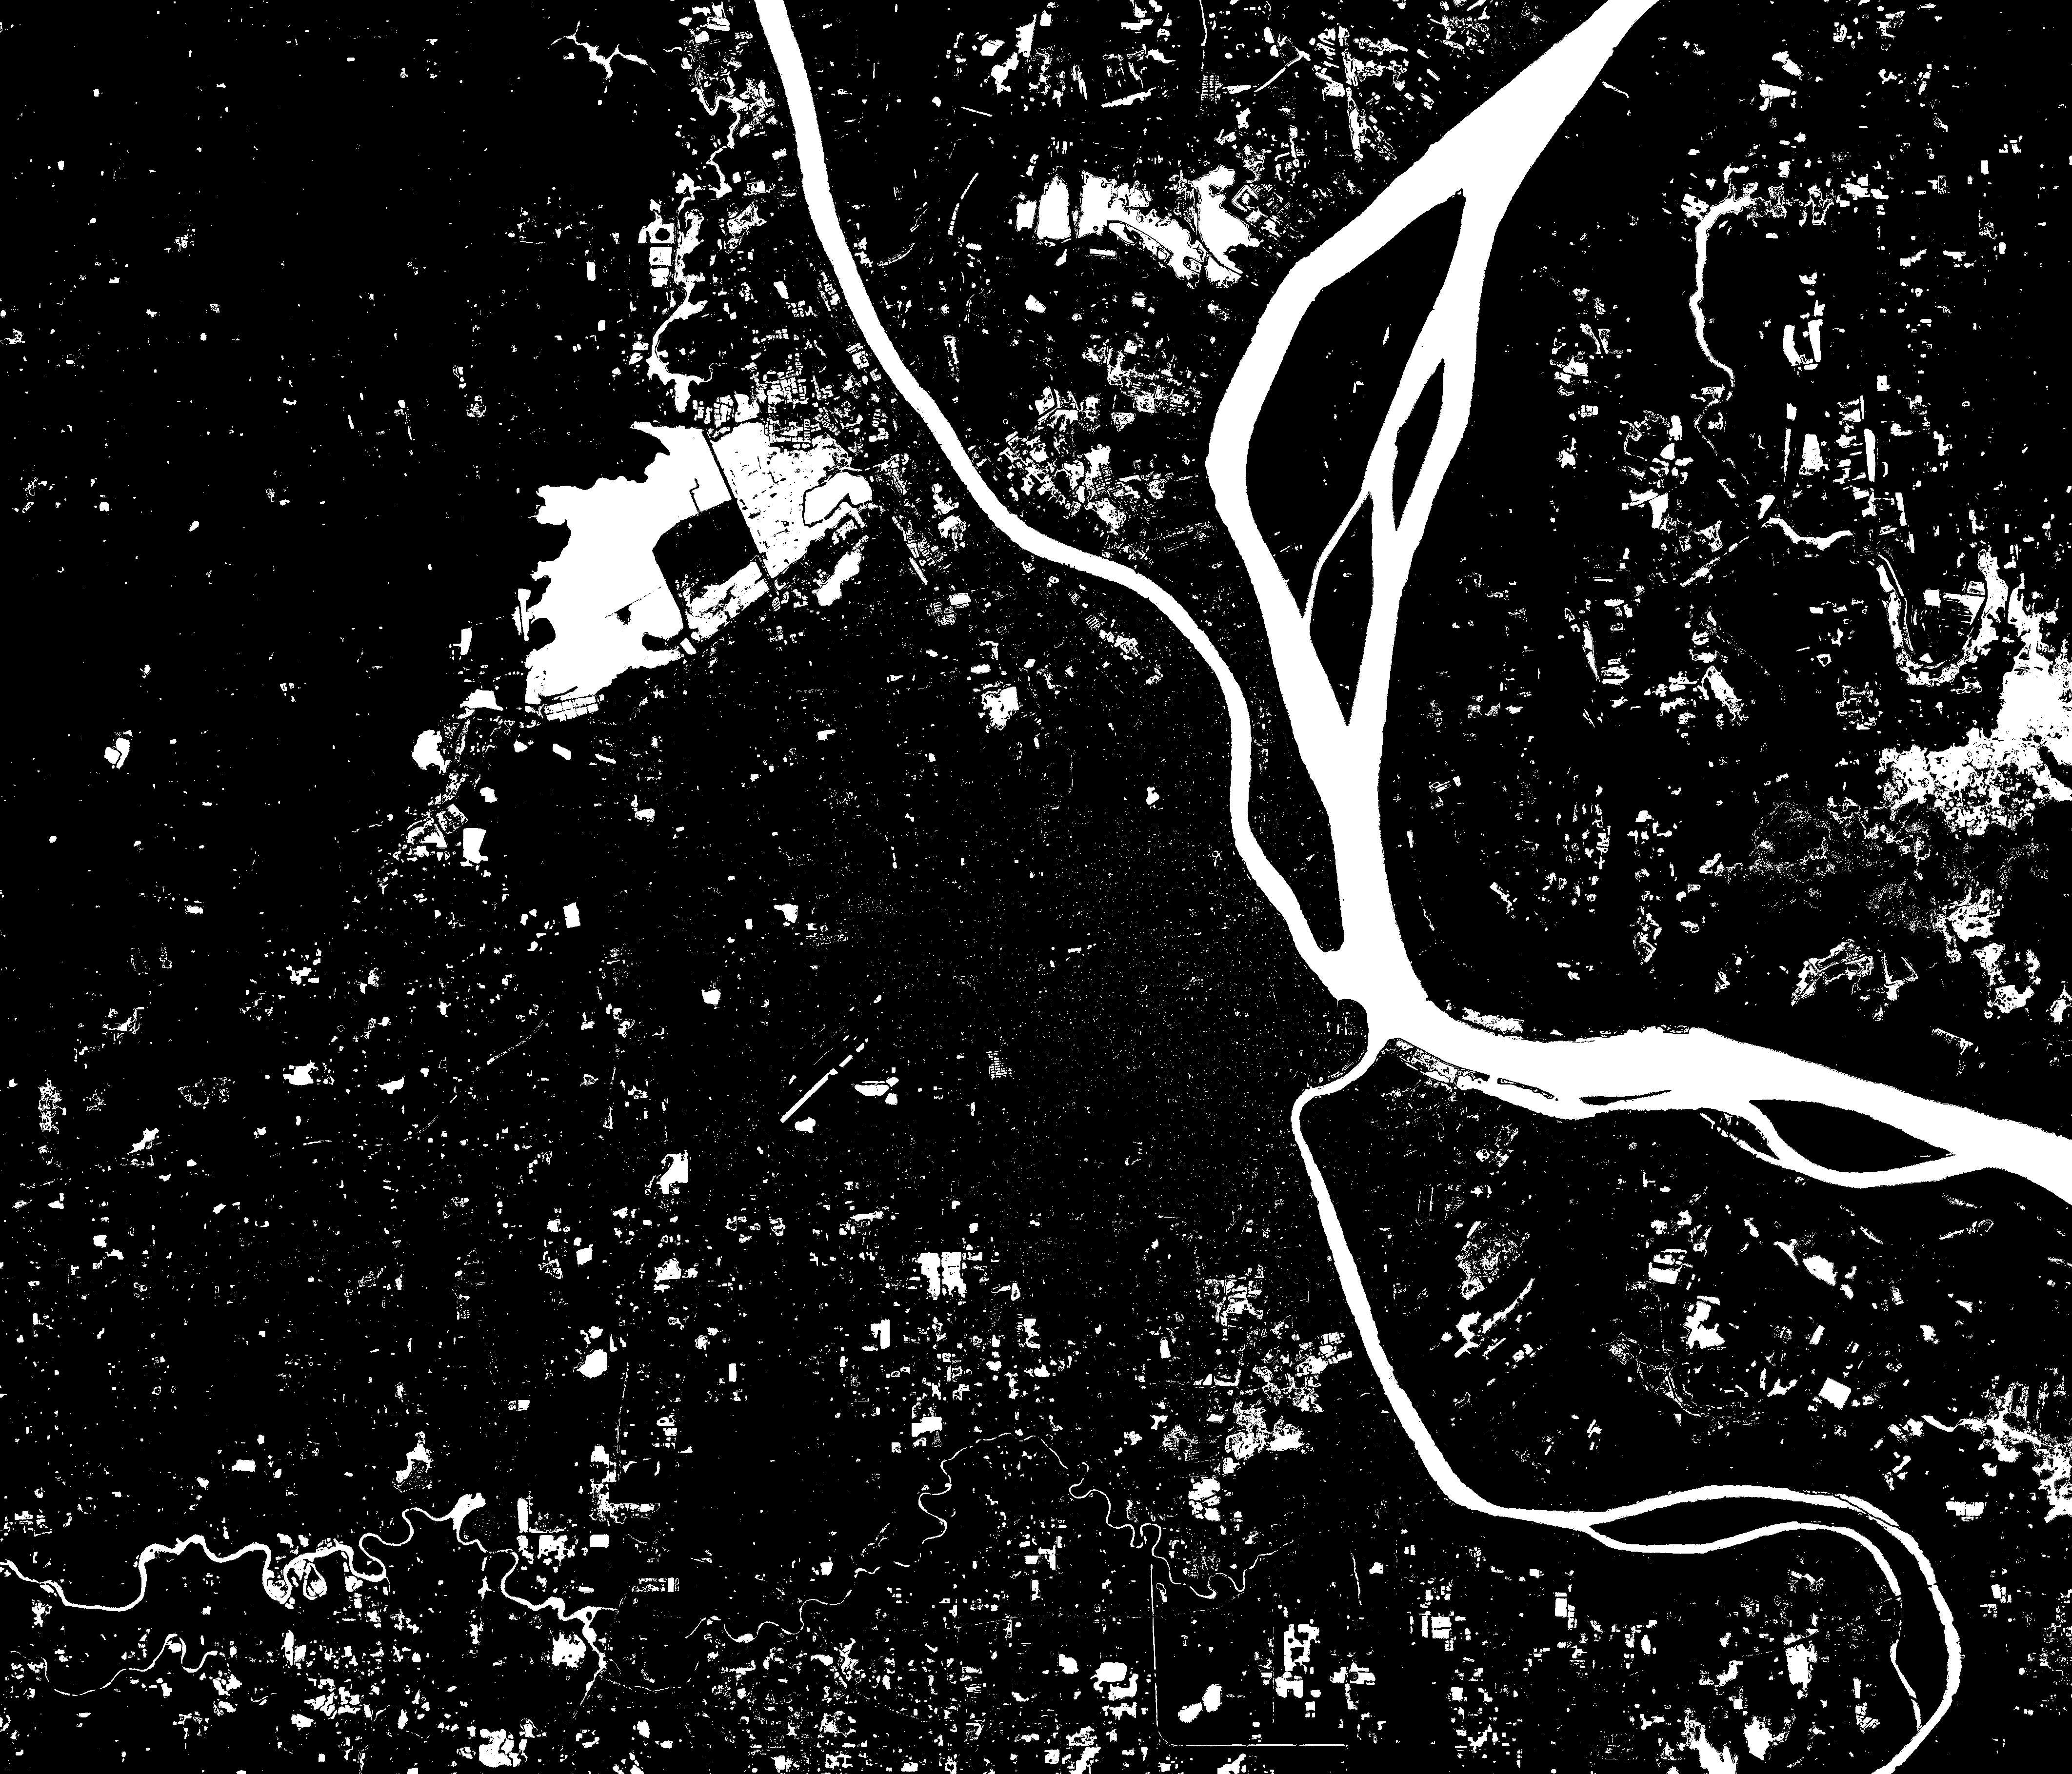

In [172]:
img_RF=Image.fromarray(255*(predicted_LULC_RF==4).astype(np.uint8))
img_RF


In [161]:
OutputFilePath_RF="./outputs/Classified_RF.tif"
with rio.open(OutputFilePath_RF,'w',driver='GTiff',width=ReadBand.width,height=ReadBand.height,count=1,crs=ReadBand.crs,transform=ReadBand.transform,dtype=np.uint8) as output:
    output.write(predicted_LULC_RF,1)
    output.close()

In [164]:
#SVM 

trainData_SVM=np.array(trainData)
testData_SVM=np.array(testData)
trainLabel_SVM=trainLabel
testLabel_SVM=testLabel

clf_SVM = SVC()    
clf_SVM.fit(trainData_SVM, trainLabel_SVM)

pred_test= clf_SVM.predict(testData_SVM)
acc=np.sum(pred_test==testLabel_SVM)/(pred_test.size)
print("The classification accuracy is {:.4f}".format(acc))

The classification accuracy is 0.5250


In [165]:
predicted_LULC_SVM=[]
column_length=S2Image[0].shape[1]


for i in tqdm(range(S2Image[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(NumOfBands):
        spectrum_data_at_row_i.append(S2Image[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class=np.transpose(clf_SVM.predict(spectrum_data_at_row_i_T))
    predicted_LULC_SVM.append(predicted_class)

predicted_LULC_SVM=np.array(predicted_LULC_SVM).astype(np.uint8)

100%|██████████| 3638/3638 [14:58<00:00,  4.05it/s]


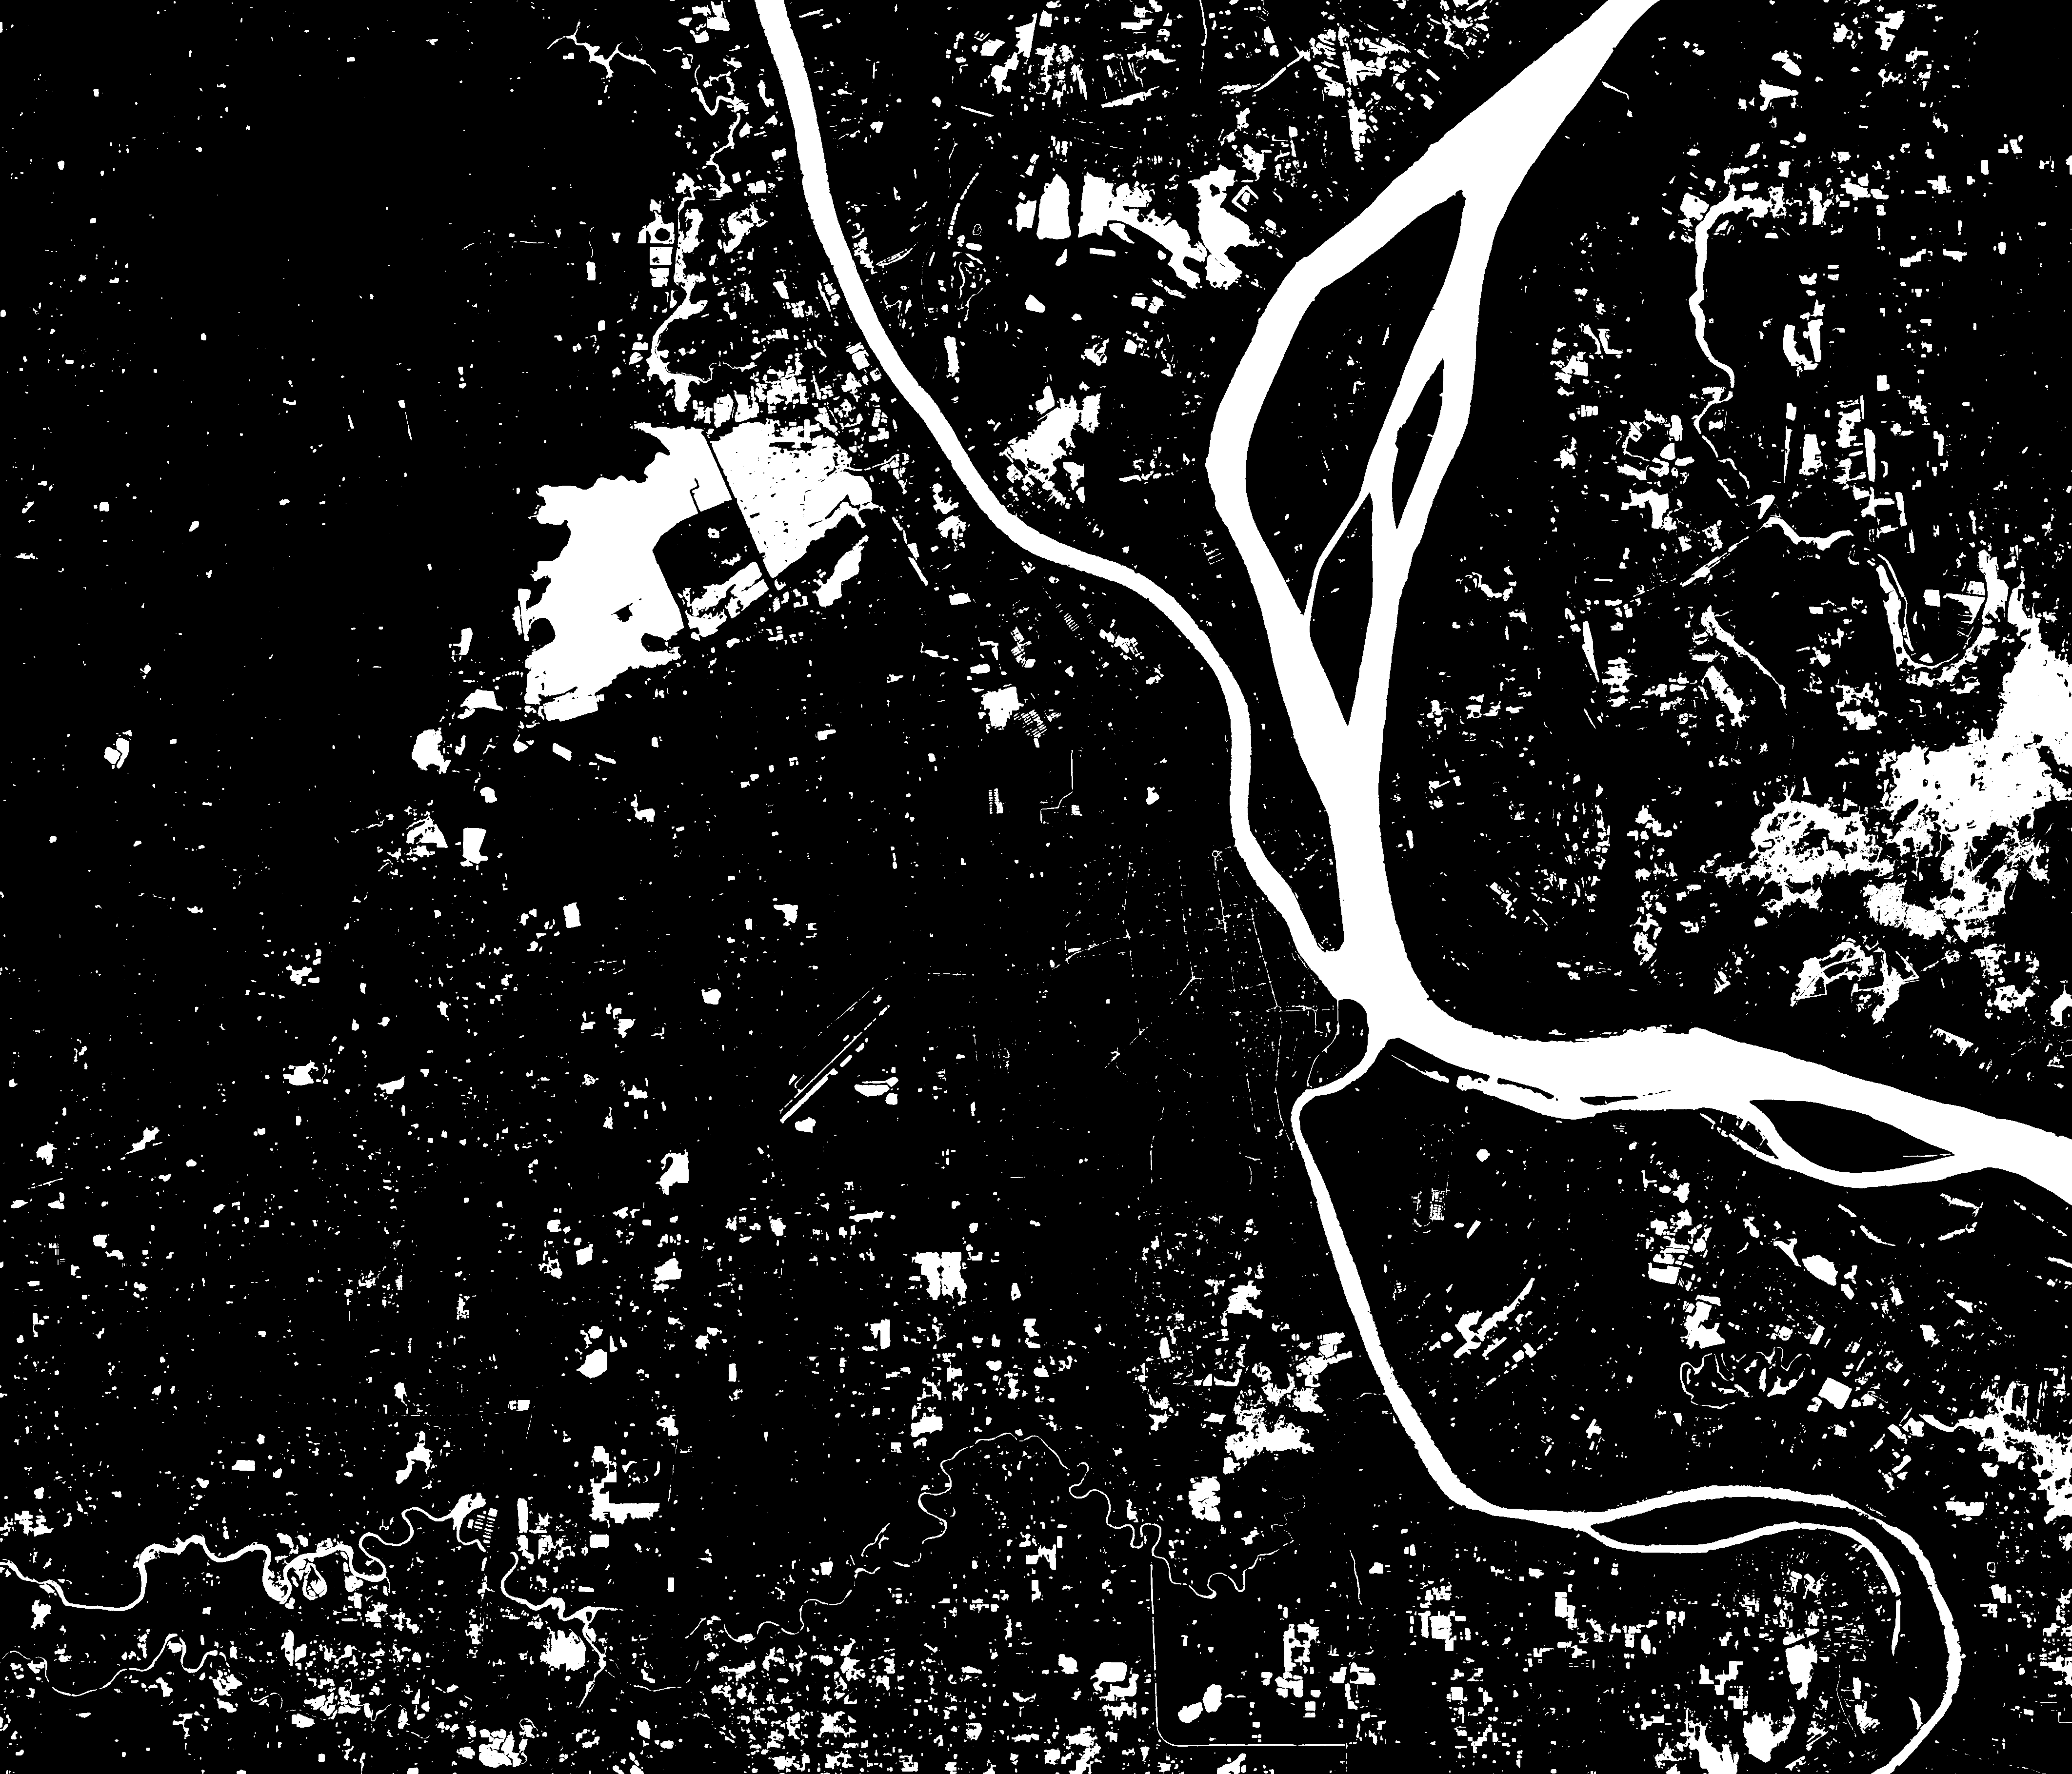

In [175]:
img_SVM=Image.fromarray(255*(predicted_LULC_SVM==4).astype(np.uint8))
img_SVM

In [176]:
OutputFilePath_SVM="./outputs/Classified_SVM.tif"
with rio.open(OutputFilePath_SVM,'w',driver='GTiff',width=ReadBand.width,height=ReadBand.height,count=1,crs=ReadBand.crs,transform=ReadBand.transform,dtype=np.uint8) as output:
    output.write(predicted_LULC_SVM,1)
    output.close()